In [1]:
import cvxpy as cp
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_WS = pd.read_csv('glm_generation_Austin/Ercot_LZ_SOUTH.csv',parse_dates=True,index_col=[0]) # For year 2016
df_WS.head()

,DA,RT
2016-01-01 00:00:00,18.22,15.48
2016-01-01 00:05:00,18.22,15.48
2016-01-01 00:10:00,18.22,15.48
2016-01-01 00:15:00,18.22,15.33
2016-01-01 00:20:00,18.22,15.33


In [3]:
start = datetime.datetime( 2016, 7, 1)
end = datetime.datetime( 2016, 7, 7, 1, 0)
interval = 300 # interval of market operation
market_intervals = pd.date_range(start,end,freq=str(int(interval/60))+'min')
market_intervals #the first hour in 5 minute increments
index = len(market_intervals)
print(len(market_intervals))

1741


In [4]:
RT = df_WS['RT']
prices = df_WS.RT[0:index]
print(prices)
#print(len(prices))

2016-01-01 00:00:00    15.48
2016-01-01 00:05:00    15.48
2016-01-01 00:10:00    15.48
2016-01-01 00:15:00    15.33
2016-01-01 00:20:00    15.33
                       ...  
2016-01-06 22:15:00    19.68
2016-01-06 22:20:00    19.68
2016-01-06 22:25:00    19.68
2016-01-06 22:30:00    19.13
2016-01-06 22:35:00    19.13
Name: RT, Length: 1741, dtype: float64


In [5]:
# Initialize price parameters
#prices = list(range(10,22))
T = len(prices)

# Initialize variables
SOC = cp.Variable((T+1,))
x = cp.Variable((T,))

# Initialize constraints
constraints = [(SOC[0]==2), (SOC[T]==2)]
for t in range(T):
    constraints += [(-1<=x[t]), (x[t]<=1), 1<=SOC[t], SOC[t]<=5, SOC[t+1]==0.99*SOC[t]+x[t]/12.]

# Objective function
#obj = cp.sum(prices*x)
obj = cp.sum(cp.multiply(prices,x))
obj = cp.Maximize(obj)

In [6]:
# Solve problem
prob = cp.Problem(obj, constraints)
profits = prob.solve() #returns optimal value = prob.value
print(profits)

20116.142682668058


In [7]:
SOC_values = SOC.value

In [8]:
# Print output and solution characteristics

print("status:", prob.status)
print("optimal value", prob.value)
print("optimal var", x.value)
print(x)

# is it ok that the x array contains values other than -1, 0, 1?

status: optimal
optimal value 20116.142682668058
optimal var [ 1.  1.  1. ... -1. -1. -1.]
var1


In [9]:
x_values = x.value
print(x_values)

[ 1.  1.  1. ... -1. -1. -1.]


In [10]:
Pd = 0
Qd = x_values[0]
SOC = 2
df_store = pd.DataFrame(columns=['timestamp', 'RT', 'SOC_t'])

In [11]:
len(x_values)

1741

In [54]:
(x_values)

array([ 1.,  1.,  1., ..., -1., -1., -1.])

In [31]:
len(df_store)
first_element=[0]
SOC_values = np.delete(SOC_values, first_element)
SOC_values.size

1741

In [44]:
df_store['timestamp'] = df_store.index

#shows which are the duplicated ones
#df_store.loc[df_store.duplicated(subset='timestamp')]

df_store.drop_duplicates(subset='timestamp', keep='last', inplace=True)
#get df_store to be same size as x_values and SOC_values
#directly write this array to dataframe column
print(df_store)

                        DA     RT  SOC_t           timestamp
2016-07-01 00:00:00  19.36  19.48    0.0 2016-07-01 00:00:00
2016-07-01 00:05:00  19.36  19.48    0.0 2016-07-01 00:05:00
2016-07-01 00:10:00  19.36  19.48    0.0 2016-07-01 00:10:00
2016-07-01 00:15:00  19.36  19.92    0.0 2016-07-01 00:15:00
2016-07-01 00:20:00  19.36  19.92    0.0 2016-07-01 00:20:00
...                    ...    ...    ...                 ...
2016-07-07 00:40:00  18.30  18.14    0.0 2016-07-07 00:40:00
2016-07-07 00:45:00  18.30  17.73    0.0 2016-07-07 00:45:00
2016-07-07 00:50:00  18.30  17.73    0.0 2016-07-07 00:50:00
2016-07-07 00:55:00  18.30  17.73    0.0 2016-07-07 00:55:00
2016-07-07 01:00:00  17.30  18.17    0.0 2016-07-07 01:00:00

[1741 rows x 4 columns]


In [45]:
len(df_store)

1741

In [57]:
df_store = df_store.copy()
df_store['SOC_t'] = 0.0
df_store = df_store.loc[start:end]
df_store['SOC_t'] = SOC_values
df_store['discharge_variable'] = x_values
df_store

,DA,RT,SOC_t,timestamp,discharge variable,discharge_variable
2016-07-01 00:00:00,19.36,19.48,2.063333,2016-07-01 00:00:00,1.0,1.0
2016-07-01 00:05:00,19.36,19.48,2.126033,2016-07-01 00:05:00,1.0,1.0
2016-07-01 00:10:00,19.36,19.48,2.188106,2016-07-01 00:10:00,1.0,1.0
2016-07-01 00:15:00,19.36,19.92,2.249559,2016-07-01 00:15:00,1.0,1.0
2016-07-01 00:20:00,19.36,19.92,2.310396,2016-07-01 00:20:00,1.0,1.0
...,...,...,...,...,...,...
2016-07-07 00:40:00,18.30,18.14,2.423877,2016-07-07 00:40:00,-1.0,-1.0
2016-07-07 00:45:00,18.30,17.73,2.316305,2016-07-07 00:45:00,-1.0,-1.0
2016-07-07 00:50:00,18.30,17.73,2.209809,2016-07-07 00:50:00,-1.0,-1.0
2016-07-07 00:55:00,18.30,17.73,2.104377,2016-07-07 00:55:00,-1.0,-1.0


In [50]:
def visualize_battery_dispatch(data):
    # Visualize battery dispatch over time as well as the market price
    fig = plt.figure(figsize=(9,3),dpi=150) 
    ax = fig.add_subplot(111)
    
    plot1 = ax.plot(data.RT, color='xkcd:sky blue', label='RT')
    ax.set_xlabel('Time')
    ax.set_ylabel('Real-time price (USD/MWh)')
    ax.set_xlim(xmin=start,xmax=end+pd.Timedelta(days=1))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
    ax.set_ylim(0.0,150)

    ax2 = ax.twinx()
    plot2 = ax2.plot(data.SOC_t, color='orange', label='SOC')
    ax2.set_ylabel('State of Charge')
    ax2.set_ylim(-4,10)
    
    
    ax3 = ax.twinx()
    rspine = ax3.spines['right']
    rspine.set_position(('axes', 1.15))
    ax3.set_frame_on(True)
    ax3.patch.set_visible(False)
    fig.subplots_adjust(right=0.7)

    plot3 = ax3.plot(data.discharge_variable, color='red', label='load')
    ax3.set_ylabel('Load Dispatched')
    ax3.set_ylim(-8,2)


    plots = plot1 + plot2 + plot3
    labs = [l.get_label() for l in plots]
    L = ax.legend(plots, labs, bbox_to_anchor=(0.5, -0.4), loc='lower center', ncol=len(labs))

<ipython-input-50-e3f038c8e736>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)


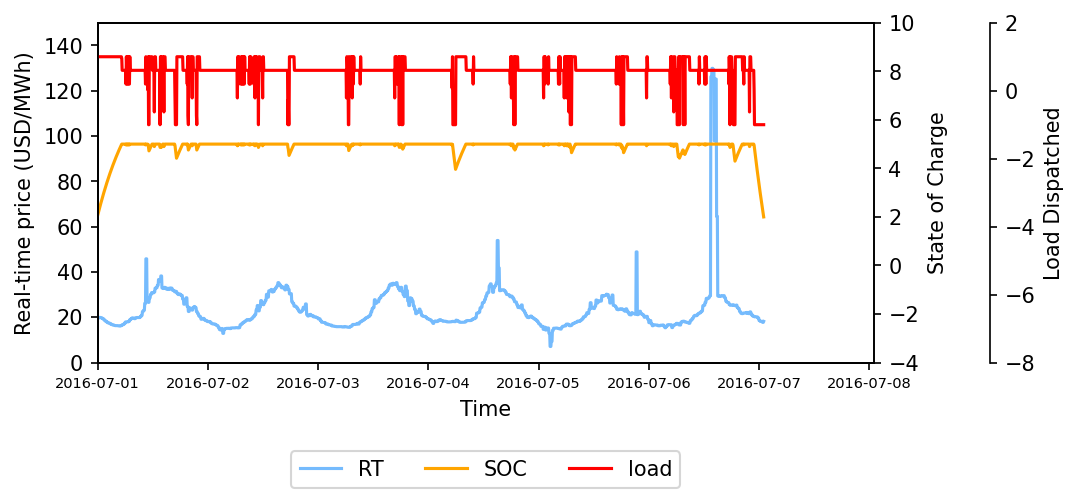

In [56]:
visualize_battery_dispatch(df_store)